In [19]:
# standard lib:
import heapq
import pathlib

# ML/data science libraries:
import numpy as np
import tensorflow as tf
from scipy import spatial
import pandas as pd

# TenserFlow/Keras classes:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import image_dataset_from_directory, load_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Rescaling, Resizing, Reshape

# plotting and imaging:
import matplotlib.pyplot as plt
from PIL import Image

## Load and Process Images:

In [3]:
data_dir = pathlib.Path('../data/e-commerce-product-images')

image_list = list(data_dir.glob('**/*.jpg'))
image_count = len(image_list)
print('image count:', image_count)

image count: 2906


In [4]:
# create dataset of images:

IMG_HEIGHT  = 224
IMG_WIDTH   = 224
BATCH_SIZE  = 1
VAL_SPLIT   = 0.2
SEED        = 7

train_set = image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    seed=SEED,
    subset='training',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_set = image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    seed=SEED,
    subset='validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2906 files belonging to 2 classes.
Using 2325 files for training.
Found 2906 files belonging to 2 classes.
Using 581 files for validation.


2022-05-21 12:53:14.524634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-21 12:53:14.524685: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-21 12:53:14.524730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ogedei): /proc/driver/nvidia/version does not exist
2022-05-21 12:53:14.525582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


AxesImage(54,36;334.8x217.44)


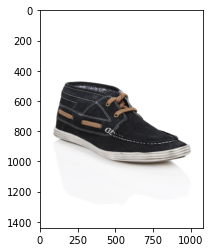

In [8]:
# explore data -- i.e. images:

# if we used PIL, we could do `PIL.Image.open(image_list[100])`:
example_img = np.array(Image.open(image_list[0]))
print(plt.imshow(example_img))

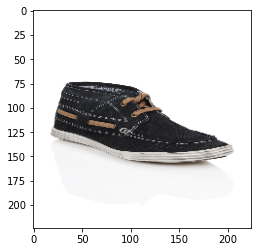

In [9]:
# processed image:

# for single images:
resize_and_scale = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH),
    Rescaling(1.0/255)
])

# for image dataset from `image_dataset_from_directory` (which already resize images):
scale = Sequential([
    Rescaling(1.0/255)
])

plt.imshow(resize_and_scale(example_img))

In [10]:
# currently the shape of images are (height, width, channels):
print('current shape of image:', example_img.shape)

# but we want to add an extra dimension for batch size, i.e. shape of (batch size, height, width, channels):
image_batch = np.expand_dims(example_img, axis=0)

current shape of image: (1440, 1080, 3)


## Load ResNet Model:

In [11]:
resnet_model = ResNet50V2(weights='imagenet')
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [12]:
# Since we're getting the "prediction" layer (last layer of ResNet), the results of the both models will be exactly the same:
extracted_feature = Model(
    name='ResNet50V2_ExtractFeature',
    inputs=resnet_model.input,
    outputs=resnet_model.get_layer('predictions').output
)

In [13]:
%%time

# n.b. if you set shuffle to True for the dataset, then using `file_paths` (a fixed list) won't work:
file_paths = train_set.file_paths
df_embeddings = pd.DataFrame(columns=['file', 'file_path', 'embedding'])

for i, (batch, _) in enumerate(train_set):
    # # see <https://stackoverflow.com/a/63734183> on how to plot image from `image_dataset_from_directory`:
    # print(plt.imshow(np.squeeze(batch.numpy().astype("uint8"))))

    processed = scale(batch)
    # if we wanted to get the embedding/feature from a single image, we'd have to use `np.expand_dims`
    # since we are processing a batch, the input shape is the expected (batch-size, height, width, channels):
    embedding = extracted_feature.predict(processed)

    df_embeddings = df_embeddings.append({'file': file_paths[i].split('/')[-1], 'file_path': file_paths[i], 'embedding': embedding}, ignore_index=True)

df_embeddings.head()

CPU times: user 20min 3s, sys: 24.7 s, total: 20min 28s
Wall time: 5min 41s


,file,file_path,embedding
0,44511.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[7.4042805e-07, 2.570189e-07, 1.0035671e-06, ..."
1,55657.jpg,../data/e-commerce-product-images/Footwear/Wom...,"[[3.1577247e-06, 2.388927e-07, 3.5804766e-07, ..."
2,34710.jpg,../data/e-commerce-product-images/Apparel/Girl...,"[[6.8054186e-07, 2.6039215e-06, 1.7150919e-06,..."
3,44779.jpg,../data/e-commerce-product-images/Footwear/Men...,"[[6.086809e-08, 2.7717377e-08, 4.9066165e-07, ..."
4,6173.jpg,../data/e-commerce-product-images/Footwear/Wom...,"[[9.5208406e-07, 3.13083e-06, 3.5109442e-06, 2..."


In [14]:
%%time

n_images = len(df_embeddings)
similarity = np.zeros((n_images, n_images))
for i in range(n_images):
    for j in range(n_images):
        # `distance.cosine` computes distance, not similarity; subtract by 1 to get similarity:
        similarity[i, j] = 1 - spatial.distance.cosine(df_embeddings.iloc[i]['embedding'], df_embeddings.iloc[j]['embedding'])

CPU times: user 21min, sys: 196 ms, total: 21min 1s
Wall time: 21min


In [15]:
# create empty dataframe with file names as both the column and index names:
file_names = df_embeddings.loc[:, 'file'].tolist()
df_similarity = pd.DataFrame(similarity, columns=file_names, index=file_names)
df_similarity.head()

,44511.jpg,55657.jpg,34710.jpg,44779.jpg,6173.jpg,30235.jpg,36746.jpg,2611.jpg,41960.jpg,22277.jpg,...,5381.jpg,59759.jpg,42750.jpg,5343.jpg,16735.jpg,33145.jpg,35588.jpg,34098.jpg,34181.jpg,39845.jpg
44511.jpg,1.000000,0.269244,0.000106,0.986110,0.986467,0.161991,0.987416,0.121900,3.489806e-06,0.000332,...,0.340200,0.000035,0.987444,0.000403,0.976369,3.893243e-06,0.152892,0.001105,0.153031,3.489569e-06
55657.jpg,0.269244,1.000000,0.000006,0.317878,0.271837,0.039332,0.268141,0.038490,3.317047e-07,0.000160,...,0.669062,0.000006,0.267457,0.000026,0.384487,3.387387e-07,0.030210,0.112857,0.030291,3.324175e-07
34710.jpg,0.000106,0.000006,1.000000,0.000008,0.000018,0.000135,0.000003,0.000037,9.821427e-01,0.035337,...,0.000207,0.000123,0.000003,0.131039,0.000003,9.823104e-01,0.000135,0.000001,0.000137,9.821423e-01
44779.jpg,0.986110,0.317878,0.000008,1.000000,0.997625,0.009875,0.998611,0.111456,2.914099e-08,0.000281,...,0.265585,0.000003,0.998570,0.000108,0.994196,5.671865e-08,0.000178,0.009863,0.000326,2.947114e-08
6173.jpg,0.986467,0.271837,0.000018,0.997625,1.000000,0.009860,0.998771,0.113455,1.833094e-06,0.000389,...,0.236663,0.000007,0.998682,0.000194,0.989369,1.945227e-06,0.000538,0.017677,0.000682,1.838770e-06


In [58]:
def find_most_similar_imgs(img_path:str, num_results:int=5):
    # load single image, process, and get embedding:
    target_img = np.array(Image.open(img_path))
    target_img_processed = resize_and_scale(target_img)
    target_embedding = extracted_feature.predict(np.expand_dims(target_img_processed, axis=0))

    # find max embedding:    
    top_matches = []
    for db_img_file_path, db_img_embedding in zip(df_embeddings['file_path'], df_embeddings['embedding']):
        similarity = 1 - spatial.distance.cosine(target_embedding, db_img_embedding)

        # ensure heap has N number of elements (this is done by adding the first N items):
        if len(top_matches) < num_results:
            heapq.heappush(top_matches, (similarity, db_img_file_path))
        # after creating an N-element heap, if a new item has a LARGER value than the SMALLEST in the heap,
        # then replace the smallest with the new item:
        elif similarity > heapq.nsmallest(1, top_matches)[0][0]: # `heapq.nsmallest` returns a list, each element in list is a tuple (similarity, file_path); hence the reason for the double subscript `[0][0]`
            heapq.heapreplace(top_matches, (similarity, db_img_file_path))

    return top_matches

top_results = find_most_similar_imgs('../data/e-commerce-product-images/Footwear/Men/Images/images_with_product_ids/1637.jpg')

In [93]:
def display_similar_imgs(img_path:str, num_results:int=5):
    top_results = find_most_similar_imgs(img_path)

    # display multiple images; see <https://stackoverflow.com/q/19471814>:
    for similarity_score, file_path in top_results: # recall `top_results` returns a tuple of (similarity, file_path)
        img = Image.open(file_path)
        plt.figure()
        plt.title(file_path.split('/')[-1]) # use file name as figure title
        plt.imshow(img)

==================== original image: ====================


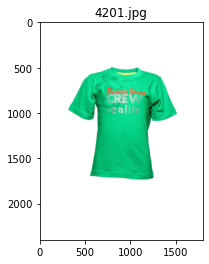

In [91]:
# example_img = '../data/e-commerce-product-images/Footwear/Men/Images/images_with_product_ids/1637.jpg'
example_img = '../data/e-commerce-product-images/Apparel/Boys/Images/images_with_product_ids/4201.jpg'

print('==================== original image: ====================')
plt.figure()
plt.title('4201.jpg')
plt.imshow(Image.open(example_img))

==================== similar images: ====================


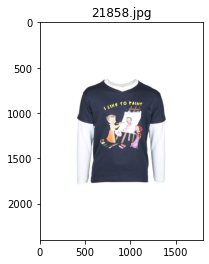

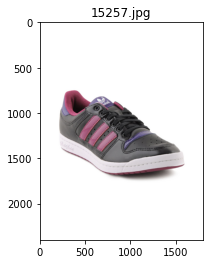

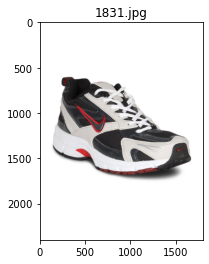

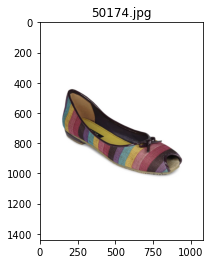

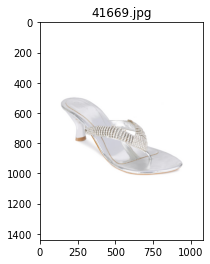

In [94]:
print('==================== similar images: ====================')
display_similar_imgs(example_img)

In [139]:
def similar_imgs(img1_path:str, img2_path:str):
    img1 = np.array(Image.open(img1_path))
    img2 = np.array(Image.open(img2_path))

    img1 = resize_and_scale(img1)
    img2 = resize_and_scale(img2)

    img1_embedding = extracted_feature.predict(np.expand_dims(img1, axis=0))
    img1_embedding = extracted_feature.predict(np.expand_dims(img2, axis=0))

    similarity = 1 - spatial.distance.cosine(img1_embedding, img1_embedding)

    return similarity


def similarity_values(img1_path:str, img2_path:str):
    img1_name = img1_path.split('/')[-1]
    img2_name = img2_path.split('/')[-1]

    results = df_similarity.loc['50174.jpg'].to_numpy()
    return results[results == 1]

In [137]:
similarity_values(
    '../data/e-commerce-product-images/Apparel/Boys/Images/images_with_product_ids/4201.jpg',
    '../data/e-commerce-product-images/Footwear/Women/Images/images_with_product_ids/41669.jpg'
)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [108]:
df_similarity.head()

,44511.jpg,55657.jpg,34710.jpg,44779.jpg,6173.jpg,30235.jpg,36746.jpg,2611.jpg,41960.jpg,22277.jpg,...,5381.jpg,59759.jpg,42750.jpg,5343.jpg,16735.jpg,33145.jpg,35588.jpg,34098.jpg,34181.jpg,39845.jpg
44511.jpg,1.000000,0.269244,0.000106,0.986110,0.986467,0.161991,0.987416,0.121900,3.489806e-06,0.000332,...,0.340200,0.000035,0.987444,0.000403,0.976369,3.893243e-06,0.152892,0.001105,0.153031,3.489569e-06
55657.jpg,0.269244,1.000000,0.000006,0.317878,0.271837,0.039332,0.268141,0.038490,3.317047e-07,0.000160,...,0.669062,0.000006,0.267457,0.000026,0.384487,3.387387e-07,0.030210,0.112857,0.030291,3.324175e-07
34710.jpg,0.000106,0.000006,1.000000,0.000008,0.000018,0.000135,0.000003,0.000037,9.821427e-01,0.035337,...,0.000207,0.000123,0.000003,0.131039,0.000003,9.823104e-01,0.000135,0.000001,0.000137,9.821423e-01
44779.jpg,0.986110,0.317878,0.000008,1.000000,0.997625,0.009875,0.998611,0.111456,2.914099e-08,0.000281,...,0.265585,0.000003,0.998570,0.000108,0.994196,5.671865e-08,0.000178,0.009863,0.000326,2.947114e-08
6173.jpg,0.986467,0.271837,0.000018,0.997625,1.000000,0.009860,0.998771,0.113455,1.833094e-06,0.000389,...,0.236663,0.000007,0.998682,0.000194,0.989369,1.945227e-06,0.000538,0.017677,0.000682,1.838770e-06


similarity: 1


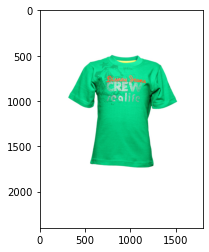

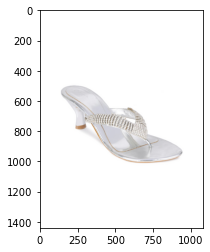

In [143]:
plt.figure()
plt.imshow(Image.open('../data/e-commerce-product-images/Apparel/Boys/Images/images_with_product_ids/4201.jpg'))
plt.figure()
plt.imshow(Image.open('../data/e-commerce-product-images/Footwear/Women/Images/images_with_product_ids/41669.jpg'))

print('similarity:',
      similar_imgs(
        '../data/e-commerce-product-images/Apparel/Boys/Images/images_with_product_ids/4201.jpg',
        '../data/e-commerce-product-images/Footwear/Women/Images/images_with_product_ids/41669.jpg'
      )
)